# Dataset: application_train.csv from the Home Credit Default Risk Kaggle competition. 
Place it in the same folder as the notebook.

In [16]:
# Imports & basic setup

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)


In [17]:
# Load dataset

# Make sure application_train.csv is in the same folder as this notebook
df = pd.read_csv("application_train.csv")

print("Shape:", df.shape)
df.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [18]:
# Target distribution & basic info

print("Target value counts:")
print(df["TARGET"].value_counts())
print("\nTarget distribution (%):")
print(df["TARGET"].value_counts(normalize=True) * 100)

print("\nData info:")
df.info()


Target value counts:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Target distribution (%):
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


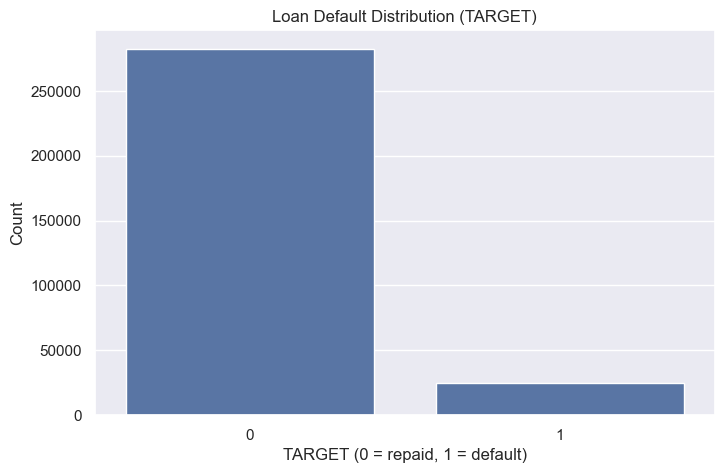

In [19]:
# Plot target distribution

sns.countplot(x="TARGET", data=df)
plt.title("Loan Default Distribution (TARGET)")
plt.xlabel("TARGET (0 = repaid, 1 = default)")
plt.ylabel("Count")
plt.show()


In [20]:
# Basic cleaning - drop ID and very missing columns. 1 drop SK_ID_CURR (just an ID), Columns with > 40% missing values (too messy)

df_clean = df.copy()

# Drop ID column if present
if "SK_ID_CURR" in df_clean.columns:
    df_clean = df_clean.drop(columns=["SK_ID_CURR"])

# Drop columns with > 40% missing values
missing_ratio = df_clean.isnull().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.40].index.tolist()
print("Dropping columns with > 40% missing values:", len(high_missing_cols))

df_clean = df_clean.drop(columns=high_missing_cols)

print("Shape after dropping high-missing columns:", df_clean.shape)


Dropping columns with > 40% missing values: 49
Shape after dropping high-missing columns: (307511, 72)


In [21]:
# Split into X (features) and y (target)

y = df_clean["TARGET"]
X = df_clean.drop(columns=["TARGET"])

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (307511, 71)
Target shape: (307511,)


In [22]:
# Separate numeric and categorical columns
# I’ll build a proper preprocessing pipeline:

# - Numeric: median imputation + scaling
# -Categorical: most frequent imputation + One-Hot Encoding


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 59
Categorical features: 12


In [23]:
# Preprocessing pipelines

# Numeric: fill missing with median, then scale
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Categorical: fill missing with most frequent, then One-Hot Encode
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [24]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps target distribution similar in train & test
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (246008, 71)
X_test: (61503, 71)


In [25]:
# Build full ML pipeline (preprocessing + model)

# I create one Pipeline that:

# 1. Preprocesses numeric + categorical features

# 2. Trains a LightGBM classifier

lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", lgbm_model)
    ]
)

clf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'FLAG_MOBIL'...
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                n_estimators=500, n_jobs=-1, random_state=42,
                                subsample=0.8))])

In [26]:
# Train / fit the model

clf.fit(X_train, y_train)

print("Training completed.")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3351
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training completed.


In [29]:
# Cell 11: Evaluation metrics

# Predicted class (0/1)
y_pred = clf.predict(X_test)

# Predicted probabilities for class 1 (default)
y_proba = clf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9196
ROC-AUC: 0.7561

Classification report:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.56      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



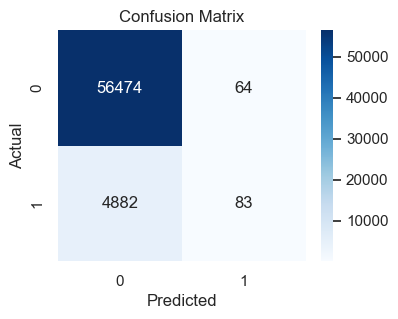

In [30]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [31]:
# I pull out the fitted LightGBM model and match feature names.
# Feature importance (top features)

# Get trained LightGBM model from the pipeline
fitted_lgbm = clf.named_steps["model"]
fitted_preprocessor = clf.named_steps["preprocessor"]

# Get feature names after preprocessing
# Numeric features stay the same
num_features_after = numeric_features

# Categorical feature names expand due to One-Hot Encoding
cat_encoder = fitted_preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_features_after = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([num_features_after, cat_features_after])

# Get importances from LightGBM
importances = fitted_lgbm.feature_importances_

feature_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
})

feature_importance = feature_importance.sort_values(by="importance", ascending=False)

# Show top 20
top_n = 20
feature_importance.head(top_n)


,feature,importance
26,EXT_SOURCE_2,1041
27,EXT_SOURCE_3,991
9,DAYS_ID_PUBLISH,914
6,DAYS_BIRTH,894
3,AMT_ANNUITY,892
7,DAYS_EMPLOYED,884
2,AMT_CREDIT,858
32,DAYS_LAST_PHONE_CHANGE,808
8,DAYS_REGISTRATION,800
1,AMT_INCOME_TOTAL,726


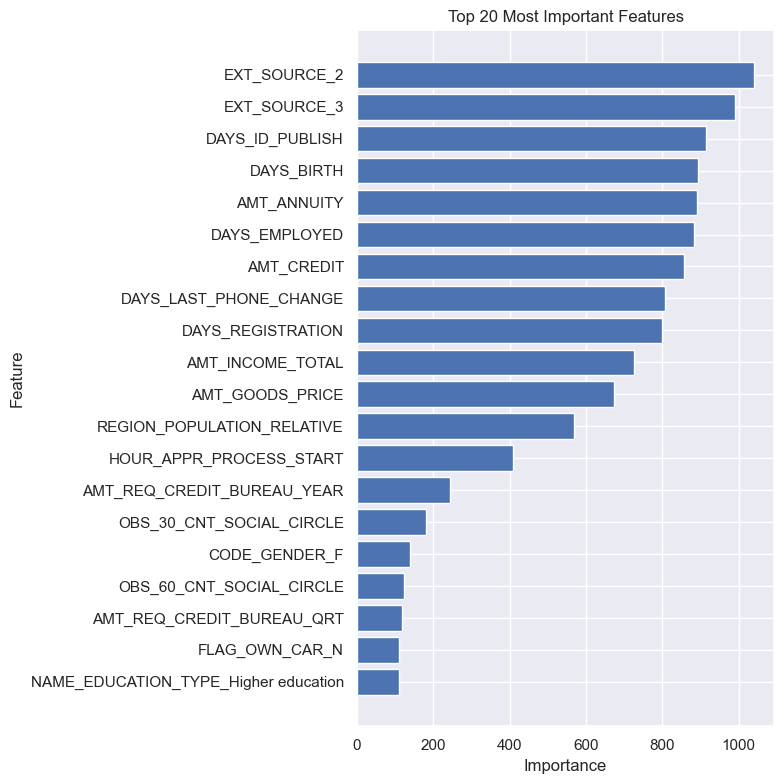

In [32]:
# Plot top 20 important features

top_features = feature_importance.head(20).sort_values(by="importance", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(top_features["feature"], top_features["importance"])
plt.title("Top 20 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


From the feature importance, we see that variables related to income, credit amount, and days employed play a major role in predicting default risk. This aligns with business intuition: customers with lower income, larger loans, or unstable employment are more likely to default.